# GSMM mixture modelling with real data

This notebook contains the following processing blocks:
- Gaussian mixture model
- Complex hierarchical gaussian filter
- Complex to real conversion
- Probabilistic Fourier transform
- Observation noise

## Import packages and functions

In [1]:
import Pkg; Pkg.activate("C:/Users/s151781/AppData/Local/Julia-1.3.1/GN/Project.toml")
using Revise
using FFTW
using Compat
using WAV
using DSP
using Base64
using ForneyLab
using LinearAlgebra
using ProgressMeter
using PyPlot
using GaussianMixtures
;

Activating environment at `C:\Users\s151781\AppData\Local\Julia-1.3.1\GN\Project.toml`


In [2]:
include("../extensions/ComplexNormal.jl")
include("../extensions/ComplexHGF.jl")
include("../extensions/ComplexToReal.jl")

include("../functions/auxiliary/workflow.jl") 
include("../functions/auxiliary/fourier.jl") 
include("../functions/auxiliary/audioplayer.jl")
include("../functions/auxiliary/visualization.jl")
include("../functions/preprocessing.jl") 
;

## Parameters

In [3]:
# data generation parameters
sound_file = "../data/woman.wav"      # specify sound location
fs = 8000                             # specify desired sampling frequency
normalization_method = "max"          # specify normalization method
nr_freqs = 19                         # number of frequencies (excluding DC and fs/2)
nr_clusters = 5                       # number of clusters (needs to be larger than 2 (ForneyLab issue))
bufsize = 2*(nr_freqs+1)              # number of samples in the buffer
stepsize = bufsize                    # step size inbetween buffers
nr_samples = Int(fs/bufsize)          # number of training samples
duration = 1                          # time of testing data

Σ_meas = 1e-10*Ic(bufsize)            # covariance matrix of measurement noise (over time in this case)
Σ_noise = 1e-2
;

## Load and process signals

In [4]:
# load speech data
x_speech, fs_speech = wavread(sound_file, format="native")
fs_speech = Int(fs_speech)
x_speech = convert(Array{Float64,1}, squeeze(x_speech[:,1]))[1*fs_speech:(1+duration)*fs_speech-1]

# pre-process signals
y_speech = preprocess(x_speech, fs_speech)[1:fs] # just 1 second!
y_speech_true = preprocess(x_speech, fs_speech)
y_speech_n = y_speech_true + sqrt(Σ_noise)*randn(size(y_speech_true))

# warp signal and take fft
f_speech = FFTovertime(y_speech, bufsize, bufsize-stepsize, rectangularwindow)
f_speech_n = FFTovertime(y_speech_n, bufsize, bufsize-stepsize, rectangularwindow)

# reduce fft 
fab_speech =  hcat(real.(f_speech[:,1]), 2*real.(f_speech[:,2:nr_freqs+1]), real.(f_speech[:,nr_freqs+2]), -real.(f_speech[:,1]), -2*imag.(f_speech[:,2:nr_freqs+1]), imag.(f_speech[:,nr_freqs+2]))
fab_speech_n =  hcat(real.(f_speech_n[:,1]), 2*real.(f_speech_n[:,2:nr_freqs+1]), real.(f_speech_n[:,nr_freqs+2]), -real.(f_speech_n[:,1]), -2*imag.(f_speech_n[:,2:nr_freqs+1]), imag.(f_speech_n[:,nr_freqs+2]))

# determine corresponding fft frequencies 
fi = abs.(FFTW.fftfreq(bufsize)[1:nr_freqs+2]*fs)[2:end-1]

# get the log abs values
z_speech = log.(abs2.(fab_speech[:,1:nr_freqs+2]) + abs2.(fab_speech[:,nr_freqs+3:end]))
z_speech_n = log.(abs2.(fab_speech_n[:,1:nr_freqs+2]) + abs2.(fab_speech_n[:,nr_freqs+3:end]))

# create time axis
t = collect(0:length(y_speech_n)-1)/fs

# create audioplayers for signals
audioplayers(y_speech, y_speech_n, fs=fs)
;

<source src="data:audio/wav;base64,UklGRjx9AABXQVZFZm10ICgAAAD+/wEAQB8AAAB9AAAEACAAFgAgAAAAAAADAAAAAAAQAIAAAKoAOJtxZGF0YQB9AADJ2T6+yKOavg3XcL6b60S+qNoTvgchp7390YM9NNk2Pgt6lz7ej9I+QFEBPzEJ/z4KJvc+OpnPPu42Ij5+9xW9i+1SvcKi2r1iLKm+4QLIvuDYcL5iWM69JWLKvW32Qb3X+E899R7jPXL4ej1cydo7wLacvRja7b2HVRW+aQRKvoGGi75LmYm+cnpIvm3CD75D6e69sIfHvOBaGz5Ndpk+L0PBPveY6z50zQM/MNoCP+Rp3z5x5k0+mvkhvEDKY70ccMm9ZDumvnuw2L4MyZa+LdrxvTRB5r3FT8a9w/FxPCnw+D34Z8c97CFWPf4j1ruxFH69xFUFvjSzLb693Xa+NEWOvmTWc77oETS+YCEEvnWtbLywQDk+Z/muPoF51D7/0P0+130PP5LYBj8MiJU+XLBbPbFeRTx90Eq9DXmUvrsb8776O7m+GMpHvk3qNr7gCUW+oURMvViQCT46+Cg+Iu2ePXR1tjwNoDg93IfbPMFr572PR3e+bz2CvuKlWb4sZ1S+TdpKvie00b10brw9m9+GPnVsuD78c9M+r2EDPw0WCz/dMs0+m7P1PXxyhTkpKOs7hvAXvhtV276Tbee+L9uLvqEuUr5xAHO+qxUhvrO9FDwT38k9zdbCPXBsTj2bkjg8g0GhPGRCijwKVOK9NM5fvpPeJb5BMHi9ZamGvbWFkbvHiGk+eVzePuD37D7DDvQ+d6DTPn46Vz5JQNs9Ue2LPTG1Jb4I19S+ep+7vozofr5Ye5K+fnecvmb0Cb7ow1E9uSrxPSLOGz7xsiQ+4a7PPbXdsj3xM6g9+Z1TvarFf77KkYO+Tw8xvtUEbr7RQpy+/PQyvkT1hzzSVaQ9aRr2PaFQdT5/xaw+15mtPtaFjD7yXGk+lwAoPpEDwD0cFEG8+5KcvaFUpL2m+eu90p5avlj4V75V2gS+O3r5vZBEGr7LL6m93WV9PAfqhboqFmu9WuKBvXPSGr1ugP+8zMbrvEWYdrs6aZE9sHlJPu8vnj7PWr8+KqvgPs6s+T4XZJI+cDp3PIgeETwd/+s8uPuEvvnO+b4Gv6C+G+URvjgygr6KpJK+MCgJvcnpLz716ik+AcYRPpphYj4OnIM+Xr9WPuPpuT3sNda8bVHhvUXiBL4XWDS+qoeEvnNnhL6Kchm+MFyjvb5Esb3IyzO9ZM1KPbvYyT26qoA9AqNGPe5nVz3DJiU9K4LSvLa8kL0KXXm9D6wevcScQr2Lzl+9f/o8vdYDqLwvOQs8z0szPEx9ibuG6ji7CS+ePNtlojt8DwC96XNJveApm7xQiJW883rgvP9yfzvZdio9koFAPRmDVT2VRJU9zQCvPfobrj0rNHE9bMQnPSe25Tzr8qc8nHGzvC/feb2h64S97ySHvQkSwr2rXtS99/ydva8qjb1u3pG9cnVovSWo9byduOK849qRvNo2Sjr4fIw8mdraPH1efT0E+LM9hXG1PW/h1j3yzw4+JAUKPuDN4D11B6E9+HprPYtSvDymQQG9vw22vYCKEb5noia+QHonvuS6Mb5GbUO+/vIavlwN1b2NCqi9p8p0vXuYjLzkdlo8ee8bPZUadD0hI5Q9pwDQPcHAJT6PSlA+cWZxPnzghD5aVHg+TWglPga31z20HGo9ys+lvXUVR75O8ly+pdxhvjepl752c52+7lFhvtVSIL5swxq+TM/TvT4fDryTrB49KJBWPQnNrD0wAwY+VNccPkQDLT7OK10+dxyMPlmpoj6gs5c+KuYVPtlQET0onos9X1LPPFQhQr5qkYm+9g0BvlVgBr6yaIm+0D5avlts2rwsWl28fOl/vX75Mj2GWBg+HJLkPb7ngz1jec09fka1PTlp3rtIY2S9E280vV/HoL1j0gW+RBQEvjXf5r1AxdS9H8yxvfIdab3OSc28BG6FvG4PpLzrbQe8BpBePCZypDxfLie8kW3Huwn1YjyBqF86Z2isvNeMCzt6fKc7IuKmvHIJy7whQW68w+5XvOUkMbzgMlO6HU8UPKrLFTyXUHY8u39RPM92BT1PRl09kaIsPfrGvzzOAQY9aUk8Pe5s4Dxf1748IQoOPUjWvjz7NMw6l5QFOneoi7vWGEm8PaRAvP21U7wOFSW8MjhevHI0uLuxaay6sB8Zu9pZCTy2lBA8UFEePAjP4DyUnNQ8M7pRPH89Az1b2Rw92a5sPHExKDxhfww9CicJPai3ZDyAij08zdiGO1JezzpjqcM81QL0O3BRrrxTig07pSG7PA9JnroJ5QK8vgcsPG7d3DoJOe07IEVaPFKkWzsufE07qzaPPP1TqDyj6kQ7qW4+PFl5hjx283Y8Vbj+PD/RDLtkTr88uH8hPUt7Cjz6N+E8t+DNPPlrybvAEZs8NMUBPepp97uv/ry8Cc5KO7g5SryMx4K8sva5OzWAK7yi7l+74JVnPPjLD703D3S8m/k8PV6tVzwELFK9VHTYvJuvUD1w/Qs8np91vTGfqzwg6+w8h72BvU9EUzzNzz49foZyvQm4Tr1/1x49OL9WvOe6gL29OgS9YkqMOm0fDr09eZW8rA2uvAPhHr03pSM8RvuUPLKsgr2dlc28EGIfPUNGz7wkYS695qeRO3EFlLp5zN287B3LvDVWAjzc3Ie8qqMgvSOtjLx5Pb+7ApCpvI5rI70kcZC8AcBdvLDYmby9kUK84YHhuwwtq7q7aIS7X/uYu0+tS7smhLU7gWSdul8kJrww79q6COAOuxt8groIjyu8MxYgvCeX7ruXEpy7iG0JO7XkuDqZLUm51UGRO/mQ9zvaELu7yNaVuyhYoLthJ0e8Ea5tvDYXWrx/6DS8aWadvJjPoLziMUu8sTmwu4OIMLu4spy7WL4NPKomezxXChM84d68O5qdODxpKgo8SPlQO5MSnTvGV88636iqORoHmzoB/7O6un63uuSMN7uI+Fo5179kOx3MiLvn+Ae8kccLvNHQO7yDtjO8Lr1DvCppzruecSC6rm+MO2p62jsfbQK6XgDFO9g/QzybUg88Db0nuiwwQjtj8CI87D9GO5Tnf7tgKJ8754ATPBJZpDtYV8W6ho+9O8ojBTzZQic8jFU8PM/NfzzOCHU8DulnPF4Zczxoby88vnUzPFXTNTyqN1k73zzNO4ThBDxoPzk8XgR9PHgKJjzRlh883fU1PKR+Hjz4Vgo8prYQPF94eDz1UlY8lg3IOwBTHzxJ90Q85iEhPE+nlzxTd6c8K2tuPO/fPTy0qnw8rWb7Oy7MqDt+Rfc7gT+Zu5jY+LsMoS68ZBe9u6EO77taZZ2798KQO4oumzvlVlM6mSktO3N7bjtmjne6sa8BvP98ILw0U2W8K/FYvNkSibwr57S876LEvJXkqLwn3r68nqXJvGj0i7yp5qS8mvayvIifuLxk5K28fXvRvHpu3rz9H9m8wS72vD9q5bxajuK8o/nUvJ0z+LwUDaG8HguLvCPRvrxD6pS8JAaSvGdgdrwrR6+8bR3ZvBHc2bw8G9S804upvFWpsby55Ky8Pn2nvDneobyG6by8hOXGvCcMo7xVE3a8uRGqvD1ol7yKRVq8f2xKvOAzVryBt627rTUyvLqLaLwDLSO8h6+ruwdhw7vpXaS7KdcVvIxIgrtip6+44iU6u0AT6zqLCIQ6nZxfO/sXljsAq6Y6n+OAO8kpejvu+O+77AtnuvdJnjpxSxk7Zn7EOlakpTtlJBk8Tz22O9QYAzyVkG08ejA4PMTqiDz9mJ88x19dPAIUgDypEjg8FBl2PApLRzx3pFU84YOEPGozIjznxiE8amNWPNgnljxeL1A8ctF8PPYapzzLsXE8ORE9POx/jTw65p88Vh22PGTrqzw9I6Q86LScPN5FzDyRf7s8lciDPA+cgDyd6

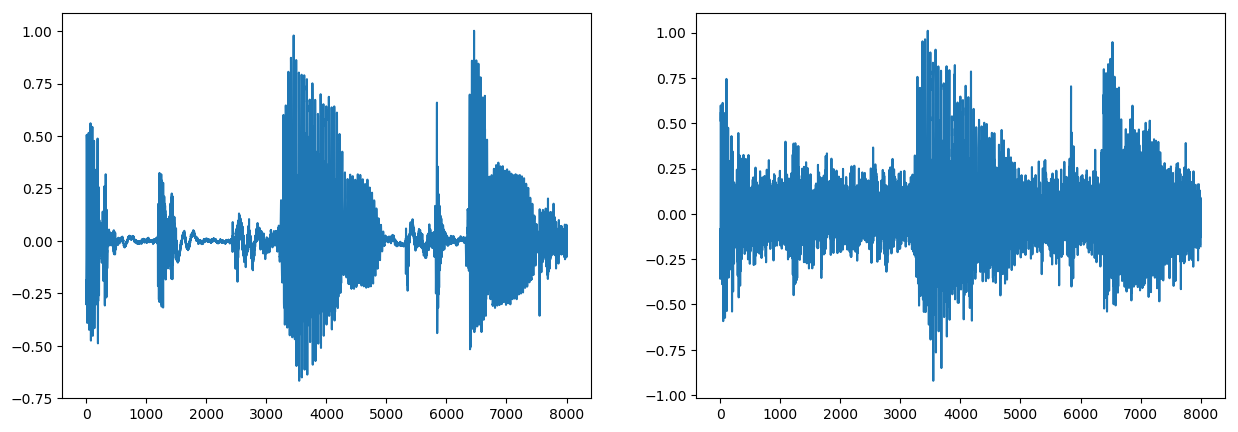

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x00000000614037B8>

In [5]:
_, ax = plt.subplots(ncols=2, figsize=(15,5))
ax[1].plot(y_speech_true)
ax[2].plot(y_speech_n)

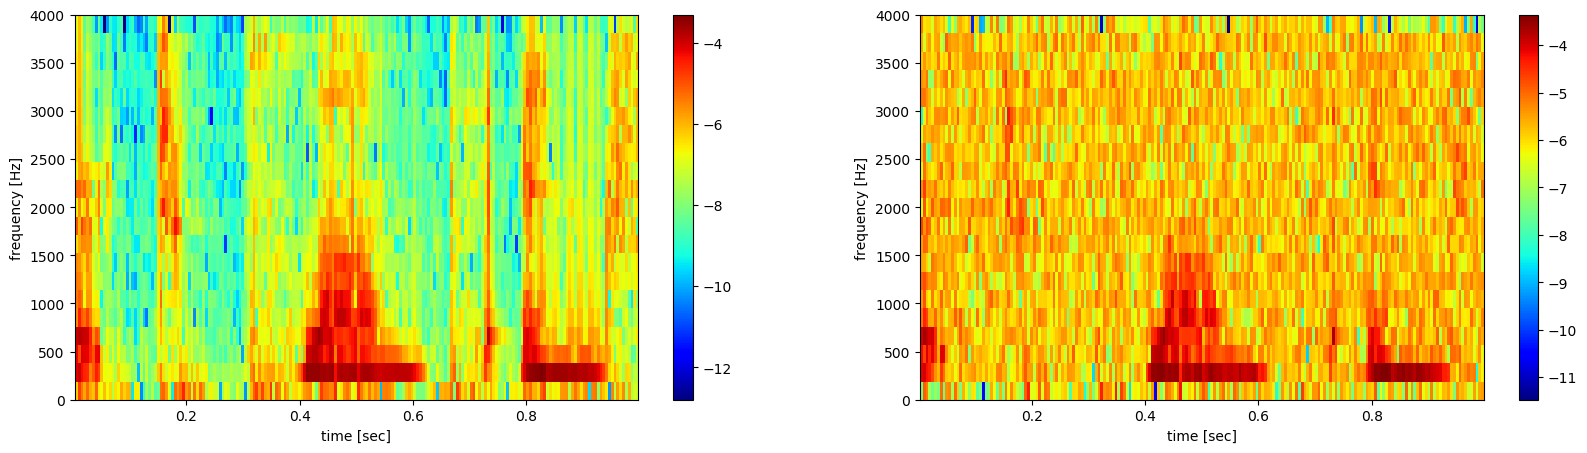

In [6]:
fig, ax = plt.subplots(ncols=2, figsize=(20,5))
plot_spectrogram(spectrogram(y_speech_true, bufsize, bufsize-stepsize, fs=fs), fs, ax=ax[1], colorbar=true)
plot_spectrogram(spectrogram(y_speech_n, bufsize, bufsize-stepsize, fs=fs), fs, ax=ax[2], colorbar=true)
;

## Train GSMM through K-means and EM

In [7]:
# perform clustering (ignore DC and fs/2)
g = GMM(nr_clusters, z_speech[:,2:end-1], nIter=50, nInit=100, kind=:diag)
em!(g, z_speech[:,2:end-1])
;

┌ Info: Initializing GMM, 5 Gaussians diag covariance 19 dimensions using 200 data points
└ @ GaussianMixtures C:\Users\s151781\.julia\packages\GaussianMixtures\3jRIL\src\train.jl:78


  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       1.835120e+04
      1       9.403852e+03      -8.947347e+03 |        5
      2       9.308061e+03      -9.579107e+01 |        3
      3       9.295231e+03      -1.283032e+01 |        4
      4       9.285863e+03      -9.367629e+00 |        2
      5       9.268195e+03      -1.766862e+01 |        3
      6       9.176288e+03      -9.190637e+01 |        3
      7       9.003761e+03      -1.725276e+02 |        3
      8       8.915157e+03      -8.860320e+01 |        4
      9       8.851671e+03      -6.348627e+01 |        3
     10       8.833793e+03      -1.787829e+01 |        2
     11       8.826746e+03      -7.047268e+00 |        2
     12       8.825143e+03      -1.602774e+00 |        0
     13       8.825143e+03       0.000000e+00 |        0
K-means converged with 13 iterations (objv = 8825.14277779577)


┌ Info: K-means with 200 data points using 13 iterations
│ 2.0 data points per parameter
└ @ GaussianMixtures C:\Users\s151781\.julia\packages\GaussianMixtures\3jRIL\src\train.jl:139


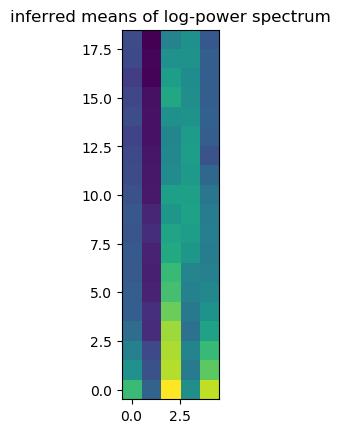

In [8]:
plt.imshow(g.μ', origin="lower")
plt.title("inferred means of log-power spectrum");

## Train GSMM through variational message passing on a factor graph

### Step 1: Build factor graph

In [9]:
# create factor graph
fg = FactorGraph()

# create distionary for variables
vars = Dict()

# specify distribution over the selection variables
@RV vars[:π] ~ ForneyLab.Dirichlet(placeholder(:α_π, dims=(nr_clusters,)))

# create mixture components
for k = 1:nr_clusters
    
    # specify distribution over precision matrix
    @RV vars[pad(:w,k)] ~ Wishart(placeholder(pad(:V_w,k), dims=(nr_freqs,nr_freqs)), placeholder(pad(:nu_w,k)))
    
    # specify distribution over mean
    @RV vars[pad(:m,k)] ~ GaussianMeanPrecision(placeholder(pad(:μ_m,k), dims=(nr_freqs,)), vars[pad(:w,k)])
    
end

# create sample-dependent random variables
for k = 1:nr_samples
    
    # specify distribution over selection variable
    @RV vars[pad(:z,k)] ~ Categorical(vars[:π])
    
    # create gaussian mixture model
    @RV vars[pad(:ξ,k)] ~ GaussianMixture(vars[pad(:z,k)], expand([[vars[pad(:m,ki)], vars[pad(:w,ki)]] for ki=1:nr_clusters])...)
    
    # log-power to complex fourier coefficients transform
    @RV vars[pad(:Xc,k)] ~ ComplexHGF(vars[pad(:ξ,k)])

    # complex fourier coefficients to real and imaginary parts concatenated
    @RV vars[pad(:Xr,k)] ~ ComplexToReal(vars[pad(:Xc,k)])
    
    # probabilistic Fourier transform
    @RV vars[pad(:x,k)] = placeholder(pad(:C,k), dims=(bufsize, 2*(nr_freqs)))*vars[pad(:Xr,k)]
    
    # observation model 
    @RV vars[pad(:y,k)] ~ GaussianMeanVariance(vars[pad(:x,k)], Σ_meas)
    
    # observation
    placeholder(vars[pad(:y,k)], :y, index=k, dims=(bufsize,))
    
end

# draw graph
if nr_samples == 1
    ForneyLab.draw(fg)
end
;

### Step 2: Generate inference algorithm

In [10]:
# specify ids for the posterior factorization
q_ids = vcat(:Π,
              expand([[pad(:M,k), pad(:W,k)] for k=1:nr_clusters]),
              :Z, :Xc, :Ξ)

# specify posterior factorization
q = PosteriorFactorization(vars[:π], 
                           expand([[vars[pad(:m,k)], vars[pad(:w,k)]] for k=1:nr_clusters])...,
                           [vars[pad(:z,k)] for k=1:nr_samples],
                           [vars[pad(:Xc,k)] for k=1:nr_samples],
                           [vars[pad(:ξ,k)] for k=1:nr_samples],
                           ids=q_ids)

# generate the inference algorithm
algo = variationalAlgorithm(q)

# Generate source code
source_code = algorithmSourceCode(algo)

# Load algorithm
eval(Meta.parse(source_code))
;

### Step 3: create data and marginals dictionary

In [11]:
y_samples = [y_speech[(k-1)*bufsize+1:k*bufsize] for k = 1:Int(length(y_speech)/bufsize)];
y_samples_n = [y_speech_n[(k-1)*bufsize+1:k*bufsize] for k = 1:Int(length(y_speech_n)/bufsize)];
t_samples = [t[(k-1)*bufsize+1:k*bufsize] for k = 1:Int(length(t)/bufsize)];
;

In [12]:
# create data dictionary
data = Dict()

# specify input data and measurement noise
data[:y] = y_samples

# specify priors over class probabilities
data[:α_π] = 1.0*ones(nr_clusters)

# specify priors over clusters
for k = 1:nr_clusters
    data[pad(:μ_m,k)] = g.μ[k,:]
    data[pad(:nu_w,k)] = (nr_freqs)
    data[pad(:V_w,k)] = diagm(1 ./g.Σ[k,:]) / (nr_freqs)
end

# specify probabilistic fourier matrices
for k = 1:nr_samples
    data[pad(:C,k)] = 1/bufsize*hcat(cos.(2*pi*fi*t_samples[k]')', sin.(2*pi*fi*t_samples[k]')')
end
;

In [13]:
# create marginals dictionary
marginals = Dict()

# specify marginals over class probabilities
marginals[:vars_π] = vague(ForneyLab.Dirichlet, nr_clusters)

# specify marginals over clusters
for k = 1:nr_clusters
    marginals[pad(:vars_m,k)] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=data[pad(:μ_m,k)], w=data[pad(:V_w,k)]*data[pad(:nu_w,k)])
    marginals[pad(:vars_w,k)] = ProbabilityDistribution(MatrixVariate, ForneyLab.Wishart, v=data[pad(:V_w,k)], nu=data[pad(:nu_w,k)])
end

# specify marginals over samples
for k = 1:nr_samples
    marginals[pad(:vars_z,k)] = ProbabilityDistribution(Categorical, p=weights(g))
    marginals[pad(:vars_Xc,k)] = ProbabilityDistribution(Multivariate, ComplexNormal, μ=zeros(nr_freqs) .+ 0.0im, Γ=1e10*Ic(nr_freqs).+0.0im, C=mat(0.0+0.0im))
    marginals[pad(:vars_ξ,k)] = ProbabilityDistribution(Multivariate, GaussianMeanVariance, m=zeros(nr_freqs), v=10*Ic(nr_freqs))
end
; 

### Step 4: Perform inference

In [14]:
# set number of iterations
nr_its = 10

# create progress bar
p = Progress(nr_its)

# perform iterations
for i = 1:nr_its
    
    # perform updates
    stepXc!(data, marginals)
    stepΞ!(data, marginals)
    stepZ!(data, marginals)
    stepΠ!(data, marginals) 
    for k = 1:nr_clusters
        getfield(Main, Symbol("stepM_"*string(k,pad=2)*"!"))(data, marginals)
        getfield(Main, Symbol("stepW_"*string(k,pad=2)*"!"))(data, marginals)
    end
    
    # update progress bar
    next!(p)
    
end

Progress: 100%|█████████████████████████████████████████| Time: 0:18:47


### Step 5: Analyze results

In [15]:
# get inferred cluster assignments and print confusion matrix
z_train_em = [findmax(llpg(g, z_speech[:,2:end-1])[k,:])[2] for k = 1:g.nx];
z_train_inf = [findmax(marginals[pad(:vars_z,k)].params[:p])[2] for k = 1:nr_samples];

# get clusters with zero assignments
remaining_clusters = unique(z_train_inf)
rm_clusters = length(remaining_clusters)

# plot confusion matrix
confusionmatrix(nr_clusters, z_train_em .- minimum(z_train_em) .+ 1, z_train_inf .- minimum(z_train_inf) .+ 1)

5×5 Array{Int64,2}:
 56   0   0   0   0
  7  43   0   0   0
  0   0  30   0   2
  4   0   0  19   2
  7   0   0   0  30

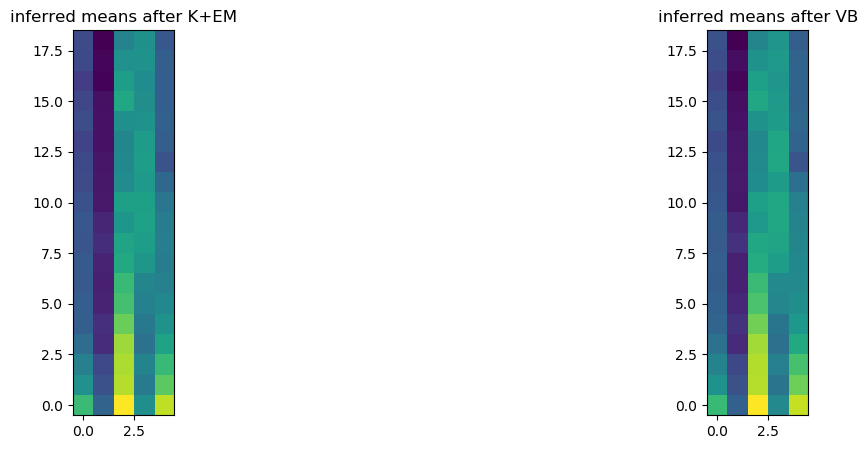

PyObject Text(0.5, 1.0, 'inferred means after VB')

In [16]:
# get new means and variances of remaining clustersand show results
μ_trained = []
V_trained = []
nu_trained = []
for k = 1:nr_clusters
    if k in remaining_clusters
        push!(μ_trained, ForneyLab.unsafeMean(marginals[pad(:vars_m,k)]))
        push!(V_trained, marginals[pad(:vars_w,k)].params[:v])
        push!(nu_trained, marginals[pad(:vars_w,k)].params[:nu])
    end
end

# get new dirichlet prior
ps = marginals[:vars_π].params[:a]

# plot new and previous means
_, ax = plt.subplots(ncols=2, figsize=(15,5))
ax[1].imshow(g.μ', origin="lower")
ax[1].set_title("inferred means after K+EM")
ax[2].imshow(hcat(μ_trained...), origin="lower")
ax[2].set_title("inferred means after VB")


## Perform speech enhancement

### Step 1: build factor graph

In [17]:
# create factor graph
fg = FactorGraph()

# create distionary for variables
vars_e = Dict()

# specify distribution over the selection variables
@RV vars_e[:π] ~ ForneyLab.Dirichlet(placeholder(:α_π, dims=(rm_clusters,)))

# create mixture components
for k = 1:rm_clusters
    
    # specify distribution over precision matrix
    @RV vars_e[pad(:w,k)] ~ Wishart(placeholder(pad(:V_w,k), dims=(nr_freqs,nr_freqs)), placeholder(pad(:nu_w,k)))
    
    # specify distribution over mean
    @RV vars_e[pad(:m,k)] ~ GaussianMeanPrecision(placeholder(pad(:μ_m,k), dims=(nr_freqs,)), vars_e[pad(:w,k)])
    
end

# specify distribution over selection variable
@RV vars_e[:z] ~ Categorical(vars_e[:π])

# create gaussian mixture model
@RV vars_e[:ξ] ~ GaussianMixture(vars_e[:z], expand([[vars_e[pad(:m,ki)], vars_e[pad(:w,ki)]] for ki=1:rm_clusters])...)

# log-power to complex fourier coefficients transform
@RV vars_e[:Xc] ~ ComplexHGF(vars_e[:ξ])

# complex fourier coefficients to real and imaginary parts concatenated
@RV vars_e[:Xr] ~ ComplexToReal(vars_e[:Xc])

# probabilistic Fourier transform
@RV vars_e[:x] = placeholder(:C, dims=(bufsize, 2*(nr_freqs)))*vars_e[:Xr]

# observation model 
@RV vars_e[:y] ~ GaussianMeanVariance(vars_e[:x], Σ_noise*Ic(bufsize))

# observation
placeholder(vars_e[:y], :y, dims=(bufsize,))
   
# draw graph
ForneyLab.draw(fg)
;

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.38.0 (20140413.2041)
 -->
<!-- Title: G Pages: 1 -->
 
 
 G 
 
<!-- 11620068960354289465 -->
 11620068960354289465 
 
 placeholder_μ_m_03 
 
<!-- 11824962215624416132 -->
 11824962215624416132 
 
 Dir 
 dirichlet_1 
 
<!-- 6620031210717960535 -->
 6620031210717960535 
 
 placeholder_α_π 
 
<!-- 11824962215624416132--6620031210717960535 -->
 11824962215624416132--6620031210717960535 
 
 α_π 
 1 out 
 2 a 
 
<!-- 11875809278818915645 -->
 11875809278818915645 
 
 = 
 equ_vars_e_w_04_1 
 
<!-- 15362171173195367944 -->
 15362171173195367944 
 
 GM 
 gaussianmixture_1 
 
<!-- 11875809278818915645--15362171173195367944 -->
 11875809278818915645--15362171173195367944 
 
 vars_e_w_04 
 10 w4 
 3 3 
 
<!-- 17652704972312909457 -->
 17652704972312909457 
 
 W 
 wishart_4 
 
<!-- 11875809278818915645--17652704972312909457 -->
 11875809278818915645--17652704972312909457 
 
 vars_e_w_04 
 1 out 
 1 1 
 
<!-- 15954218793783717845 -->
 15954218793783717845 
 
 𝒩 
 gaussianmeanprecision_4 
 
<!-- 11875809278818915645--15954218793783717845 -->
 11875809278818915645--15954218793783717845 
 
 vars_e_w_04 
 3 w 
 2 2 
 
<!-- 14673153148947694616 -->
 14673153148947694616 
 
 = 
 equ_vars_e_w_02_1 
 
<!-- 6492699947060338081 -->
 6492699947060338081 
 
 W 
 wishart_2 
 
<!-- 14673153148947694616--6492699947060338081 -->
 14673153148947694616--6492699947060338081 
 
 vars_e_w_02 
 1 out 
 1 1 
 
<!-- 655505472550765981 -->
 655505472550765981 
 
 𝒩 
 gaussianmeanprecision_2 
 
<!-- 14673153148947694616--655505472550765981 -->
 14673153148947694616--655505472550765981 
 
 vars_e_w_02 
 3 w 
 2 2 
 
<!-- 14673153148947694616--15362171173195367944 -->
 14673153148947694616--15362171173195367944 
 
 vars_e_w_02 
 6 w2 
 3 3 
 
<!-- 7312982982367619231 -->
 7312982982367619231 
 
 𝒩 
 gaussianmeanprecision_3 
 
<!-- 7312982982367619231--11620068960354289465 -->
 7312982982367619231--11620068960354289465 
 
 μ_m_03 
 1 out 
 2 m 
 
<!-- 6490248828811609096 -->
 6490248828811609096 
 
 placeholder_V_w_02 
 
<!-- 6492699947060338081--6490248828811609096 -->
 6492699947060338081--6490248828811609096 
 
 V_w_02 
 1 out 
 2 v 
 
<!-- 2729711533689259111 -->
 2729711533689259111 
 
 placeholder_nu_w_02 
 
<!-- 6492699947060338081--2729711533689259111 -->
 6492699947060338081--2729711533689259111 
 
 nu_w_02 
 1 out 
 3 nu 
 
<!-- 5052644702037309092 -->
 5052644702037309092 
 
 placeholder_μ_m_02 
 
<!-- 655505472550765981--5052644702037309092 -->
 655505472550765981--5052644702037309092 
 
 μ_m_02 
 1 out 
 2 m 
 
<!-- 1836019267362183120 -->
 1836019267362183120 
 
 placeholder_V_w_04 
 
<!-- 4599589058702347146 -->
 4599589058702347146 
 
 placeholder_μ_m_01 
 
<!-- 123968014445455606 -->
 123968014445455606 
 
 placeholder_nu_w_01 
 
<!-- 17995134174392128568 -->
 17995134174392128568 
 
 = 
 equ_vars_e_w_01_1 
 
<!-- 17995134174392128568--15362171173195367944 -->
 17995134174392128568--15362171173195367944 
 
 vars_e_w_01 
 4 w1 
 3 3 
 
<!-- 7879800004493832363 -->
 7879800004493832363 
 
 𝒩 
 gaussianmeanprecision_1 
 
<!-- 17995134174392128568--7879800004493832363 -->
 17995134174392128568--7879800004493832363 
 
 vars_e_w_01 
 3 w 
 2 2 
 
<!-- 2756809650489310725 -->
 2756809650489310725 
 
 W 
 wishart_1 
 
<!-- 17995134174392128568--2756809650489310725 -->
 17995134174392128568--2756809650489310725 
 
 vars_e_w_01 
 1 out 
 1 1 
 
<!-- 8917515896505713237 -->
 8917515896505713237 
 
 ComplexToReal 
 complextoreal_1 
 
<!-- 8601153851638412564 -->
 8601153851638412564 
 
 ComplexHGF 
 complexhgf_1 
 
<!-- 8917515896505713237--8601153

### Step 2: Generate inference algorithm

In [18]:
# specify ids for the posterior factorization
q_ids = vcat(:Π,
              expand([[pad(:M,k), pad(:W,k)] for k=1:rm_clusters]),
              :Z, :Xc, :Ξ)

# specify posterior factorization
q = PosteriorFactorization(vars_e[:π], 
                           expand([[vars_e[pad(:m,k)], vars_e[pad(:w,k)]] for k=1:rm_clusters])...,
                           vars_e[:z], vars_e[:Xc], vars_e[:ξ], ids=q_ids)

# generate the inference algorithm
algo = variationalAlgorithm(q)

# Generate source code
source_code = algorithmSourceCode(algo)

# Load algorithm
eval(Meta.parse(source_code))
;

### Step 3: inference

In [19]:
# create placeholders
ξ_inferred = Array{Float64, 2}(undef, nr_samples*duration, nr_freqs)
x_inferred = Array{Float64, 2}(undef, nr_samples*duration, bufsize)

# loop through segments
@showprogress for k = 1:nr_samples*duration
    
    # set number of iterations
    nr_its = 10

    # create data dictionary
    data = Dict()

    # specify input data and measurement noise
    data[:y] = y_samples_n[k] .- mean(y_samples_n[k])

    # specify priors over class probabilities
    data[:α_π] = ps

    # specify priors over clusters
    for ki = 1:rm_clusters
        data[pad(:μ_m,ki)] = μ_trained[ki]
        data[pad(:nu_w,ki)] = nu_trained[ki]
        data[pad(:V_w,ki)] =  V_trained[ki]
    end

    # specify probabilistic fourier matrices
    data[:C] = 1/bufsize*hcat(cos.(2*pi*fi*t_samples[k]')', sin.(2*pi*fi*t_samples[k]')')
    

    # create marginals dictionary
    marginals = Dict()

    # specify marginals over class probabilities
    marginals[:vars_e_π] = ProbabilityDistribution(ForneyLab.Dirichlet, a=ps)

    # specify marginals over clusters
    for ki = 1:rm_clusters
        marginals[pad(:vars_e_m,ki)] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=data[pad(:μ_m,ki)], w=data[pad(:V_w,ki)]*data[pad(:nu_w,ki)])
        marginals[pad(:vars_e_w,ki)] = ProbabilityDistribution(MatrixVariate, ForneyLab.Wishart, v=data[pad(:V_w,ki)], nu=data[pad(:nu_w,ki)])
    end
    
    # specify marginals over samples
    #marginals[:vars_e_z] = vague(Categorical)
    #marginals[:vars_e_z] = ProbabilityDistribution(Categorical, p=ps/sum(ps))
    marginals[:vars_e_z] = ProbabilityDistribution(Categorical, p=exp.(ps)/sum(exp.(ps))) # not sure whether best way
    marginals[:vars_e_Xc] = ProbabilityDistribution(Multivariate, ComplexNormal, μ=zeros(nr_freqs) .+ 0.0im, Γ=1e10*Ic(nr_freqs).+0.0im, C=mat(0.0+0.0im))
    marginals[:vars_e_ξ] = ProbabilityDistribution(Multivariate, GaussianMeanVariance, m=z_speech_n[k,2:end-1], v=1*Ic(nr_freqs))
                    
    # perform iterations
    for i = 1:nr_its

        # perform updates
        stepXc!(data, marginals)
        stepΞ!(data, marginals)
        stepZ!(data, marginals)
        
    end
    try
        ξ_inferred[k,:] = ForneyLab.unsafeMean(marginals[:vars_e_ξ])
        x_inferred[k,:] = ForneyLab.unsafeMean(marginals[:vars_e_x]) .+ mean(y_samples_n[k])
    catch
        ξ_inferred[k,:] = zeros(nr_freqs)
        x_inferred[k,:] = zeros(bufsize)
        println("Posdef Exception, k="*string(k))
    end
end

Progress:   6%|███                                      |  ETA: 0:00:29

Posdef Exception, k=11


Progress:  20%|█████████                                |  ETA: 0:00:20

Posdef Exception, k=42

Progress:  22%|█████████                                |  ETA: 0:00:20

Progress:  22%|██████████                               |  ETA: 0:00:19

Posdef Exception, k=46

Progress:  24%|██████████                               |  ETA: 0:00:19

Progress:  32%|██████████████                           |  ETA: 0:00:16

Posdef Exception, k=66

Progress:  34%|██████████████                           |  ETA: 0:00:16

Progress:  34%|███████████████                          |  ETA: 0:00:15

Posdef Exception, k=69


Progress:  40%|█████████████████                        |  ETA: 0:00:14

Posdef Exception, k=79


Progress:  66%|███████████████████████████              |  ETA: 0:00:08

Posdef Exception, k=131


Progress:  70%|█████████████████████████████            |  ETA: 0:00:07

Posdef Exception, k=141


Progress:  72%|██████████████████████████████           |  ETA: 0:00:07

Posdef Exception, k=144

Progress:  72%|██████████████████████████████           |  ETA: 0:00:06

Progress:  74%|███████████████████████████████          |  ETA: 0:00:06

Posdef Exception, k=149


Progress:  76%|███████████████████████████████          |  ETA: 0:00:06

Posdef Exception, k=152


Progress:  99%|█████████████████████████████████████████|  ETA: 0:00:00

Posdef Exception, k=199
Posdef Exception, k=200


Progress: 100%|█████████████████████████████████████████| Time: 0:00:22


### Step 4: results

In [20]:
# reshape enhance speech signal
y_enhanced = vcat(x_inferred'...)
;

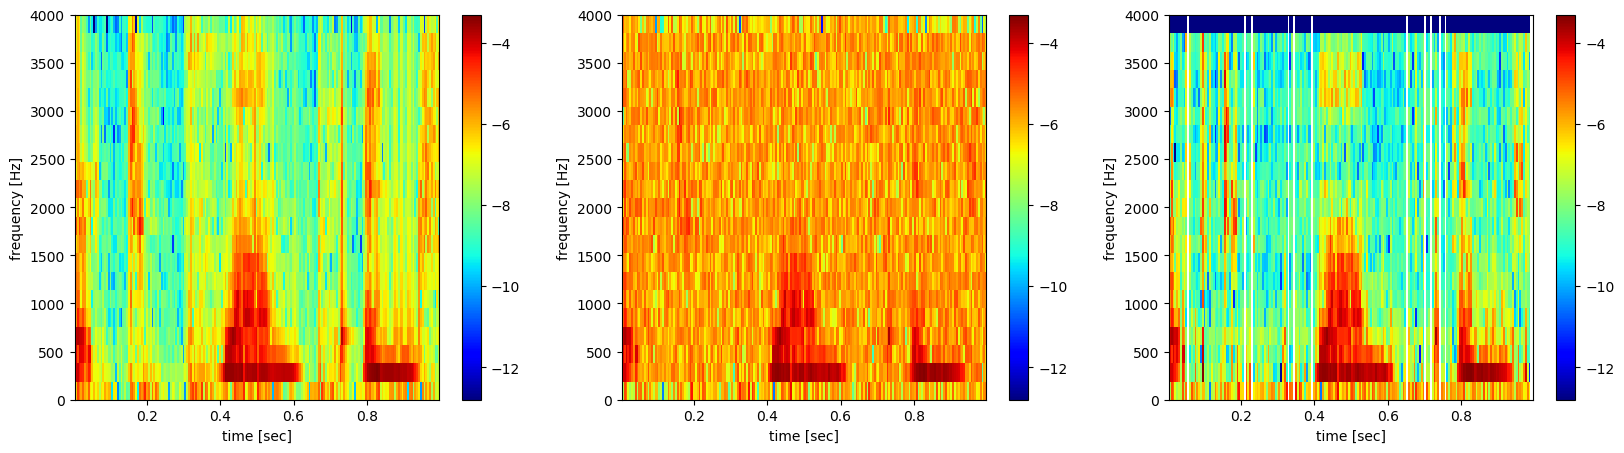

In [21]:
#plt.imshow(ξ_inferred',origin="lower", aspect="auto"), plt.colorbar()
fig, ax = plt.subplots(ncols=3, figsize=(20,5))
cmp = plot_spectrogram(spectrogram(y_speech_true, bufsize, bufsize-stepsize, fs=fs), fs, ax=ax[1], colorbar=true)
plot_spectrogram(spectrogram(y_speech_n, bufsize, bufsize-stepsize, fs=fs), fs, ax=ax[2])
plot_spectrogram(spectrogram(y_enhanced, bufsize, bufsize-stepsize, fs=fs), fs, ax=ax[3])
vrange = ax[1].get_images()[1].get_clim()
fig.colorbar(cmp, ax=ax[2])
ax[2].get_images()[1].set_clim(vrange)
fig.colorbar(cmp, ax=ax[3])
ax[3].get_images()[1].set_clim(vrange)
;

<source src="data:audio/wav;base64,UklGRjx9AABXQVZFZm10ICgAAAD+/wEAQB8AAAB9AAAEACAAFgAgAAAAAAADAAAAAAAQAIAAAKoAOJtxZGF0YQB9AADJ2T6+yKOavg3XcL6b60S+qNoTvgchp7390YM9NNk2Pgt6lz7ej9I+QFEBPzEJ/z4KJvc+OpnPPu42Ij5+9xW9i+1SvcKi2r1iLKm+4QLIvuDYcL5iWM69JWLKvW32Qb3X+E899R7jPXL4ej1cydo7wLacvRja7b2HVRW+aQRKvoGGi75LmYm+cnpIvm3CD75D6e69sIfHvOBaGz5Ndpk+L0PBPveY6z50zQM/MNoCP+Rp3z5x5k0+mvkhvEDKY70ccMm9ZDumvnuw2L4MyZa+LdrxvTRB5r3FT8a9w/FxPCnw+D34Z8c97CFWPf4j1ruxFH69xFUFvjSzLb693Xa+NEWOvmTWc77oETS+YCEEvnWtbLywQDk+Z/muPoF51D7/0P0+130PP5LYBj8MiJU+XLBbPbFeRTx90Eq9DXmUvrsb8776O7m+GMpHvk3qNr7gCUW+oURMvViQCT46+Cg+Iu2ePXR1tjwNoDg93IfbPMFr572PR3e+bz2CvuKlWb4sZ1S+TdpKvie00b10brw9m9+GPnVsuD78c9M+r2EDPw0WCz/dMs0+m7P1PXxyhTkpKOs7hvAXvhtV276Tbee+L9uLvqEuUr5xAHO+qxUhvrO9FDwT38k9zdbCPXBsTj2bkjg8g0GhPGRCijwKVOK9NM5fvpPeJb5BMHi9ZamGvbWFkbvHiGk+eVzePuD37D7DDvQ+d6DTPn46Vz5JQNs9Ue2LPTG1Jb4I19S+ep+7vozofr5Ye5K+fnecvmb0Cb7ow1E9uSrxPSLOGz7xsiQ+4a7PPbXdsj3xM6g9+Z1TvarFf77KkYO+Tw8xvtUEbr7RQpy+/PQyvkT1hzzSVaQ9aRr2PaFQdT5/xaw+15mtPtaFjD7yXGk+lwAoPpEDwD0cFEG8+5KcvaFUpL2m+eu90p5avlj4V75V2gS+O3r5vZBEGr7LL6m93WV9PAfqhboqFmu9WuKBvXPSGr1ugP+8zMbrvEWYdrs6aZE9sHlJPu8vnj7PWr8+KqvgPs6s+T4XZJI+cDp3PIgeETwd/+s8uPuEvvnO+b4Gv6C+G+URvjgygr6KpJK+MCgJvcnpLz716ik+AcYRPpphYj4OnIM+Xr9WPuPpuT3sNda8bVHhvUXiBL4XWDS+qoeEvnNnhL6Kchm+MFyjvb5Esb3IyzO9ZM1KPbvYyT26qoA9AqNGPe5nVz3DJiU9K4LSvLa8kL0KXXm9D6wevcScQr2Lzl+9f/o8vdYDqLwvOQs8z0szPEx9ibuG6ji7CS+ePNtlojt8DwC96XNJveApm7xQiJW883rgvP9yfzvZdio9koFAPRmDVT2VRJU9zQCvPfobrj0rNHE9bMQnPSe25Tzr8qc8nHGzvC/feb2h64S97ySHvQkSwr2rXtS99/ydva8qjb1u3pG9cnVovSWo9byduOK849qRvNo2Sjr4fIw8mdraPH1efT0E+LM9hXG1PW/h1j3yzw4+JAUKPuDN4D11B6E9+HprPYtSvDymQQG9vw22vYCKEb5noia+QHonvuS6Mb5GbUO+/vIavlwN1b2NCqi9p8p0vXuYjLzkdlo8ee8bPZUadD0hI5Q9pwDQPcHAJT6PSlA+cWZxPnzghD5aVHg+TWglPga31z20HGo9ys+lvXUVR75O8ly+pdxhvjepl752c52+7lFhvtVSIL5swxq+TM/TvT4fDryTrB49KJBWPQnNrD0wAwY+VNccPkQDLT7OK10+dxyMPlmpoj6gs5c+KuYVPtlQET0onos9X1LPPFQhQr5qkYm+9g0BvlVgBr6yaIm+0D5avlts2rwsWl28fOl/vX75Mj2GWBg+HJLkPb7ngz1jec09fka1PTlp3rtIY2S9E280vV/HoL1j0gW+RBQEvjXf5r1AxdS9H8yxvfIdab3OSc28BG6FvG4PpLzrbQe8BpBePCZypDxfLie8kW3Huwn1YjyBqF86Z2isvNeMCzt6fKc7IuKmvHIJy7whQW68w+5XvOUkMbzgMlO6HU8UPKrLFTyXUHY8u39RPM92BT1PRl09kaIsPfrGvzzOAQY9aUk8Pe5s4Dxf1748IQoOPUjWvjz7NMw6l5QFOneoi7vWGEm8PaRAvP21U7wOFSW8MjhevHI0uLuxaay6sB8Zu9pZCTy2lBA8UFEePAjP4DyUnNQ8M7pRPH89Az1b2Rw92a5sPHExKDxhfww9CicJPai3ZDyAij08zdiGO1JezzpjqcM81QL0O3BRrrxTig07pSG7PA9JnroJ5QK8vgcsPG7d3DoJOe07IEVaPFKkWzsufE07qzaPPP1TqDyj6kQ7qW4+PFl5hjx283Y8Vbj+PD/RDLtkTr88uH8hPUt7Cjz6N+E8t+DNPPlrybvAEZs8NMUBPepp97uv/ry8Cc5KO7g5SryMx4K8sva5OzWAK7yi7l+74JVnPPjLD703D3S8m/k8PV6tVzwELFK9VHTYvJuvUD1w/Qs8np91vTGfqzwg6+w8h72BvU9EUzzNzz49foZyvQm4Tr1/1x49OL9WvOe6gL29OgS9YkqMOm0fDr09eZW8rA2uvAPhHr03pSM8RvuUPLKsgr2dlc28EGIfPUNGz7wkYS695qeRO3EFlLp5zN287B3LvDVWAjzc3Ie8qqMgvSOtjLx5Pb+7ApCpvI5rI70kcZC8AcBdvLDYmby9kUK84YHhuwwtq7q7aIS7X/uYu0+tS7smhLU7gWSdul8kJrww79q6COAOuxt8groIjyu8MxYgvCeX7ruXEpy7iG0JO7XkuDqZLUm51UGRO/mQ9zvaELu7yNaVuyhYoLthJ0e8Ea5tvDYXWrx/6DS8aWadvJjPoLziMUu8sTmwu4OIMLu4spy7WL4NPKomezxXChM84d68O5qdODxpKgo8SPlQO5MSnTvGV88636iqORoHmzoB/7O6un63uuSMN7uI+Fo5179kOx3MiLvn+Ae8kccLvNHQO7yDtjO8Lr1DvCppzruecSC6rm+MO2p62jsfbQK6XgDFO9g/QzybUg88Db0nuiwwQjtj8CI87D9GO5Tnf7tgKJ8754ATPBJZpDtYV8W6ho+9O8ojBTzZQic8jFU8PM/NfzzOCHU8DulnPF4Zczxoby88vnUzPFXTNTyqN1k73zzNO4ThBDxoPzk8XgR9PHgKJjzRlh883fU1PKR+Hjz4Vgo8prYQPF94eDz1UlY8lg3IOwBTHzxJ90Q85iEhPE+nlzxTd6c8K2tuPO/fPTy0qnw8rWb7Oy7MqDt+Rfc7gT+Zu5jY+LsMoS68ZBe9u6EO77taZZ2798KQO4oumzvlVlM6mSktO3N7bjtmjne6sa8BvP98ILw0U2W8K/FYvNkSibwr57S876LEvJXkqLwn3r68nqXJvGj0i7yp5qS8mvayvIifuLxk5K28fXvRvHpu3rz9H9m8wS72vD9q5bxajuK8o/nUvJ0z+LwUDaG8HguLvCPRvrxD6pS8JAaSvGdgdrwrR6+8bR3ZvBHc2bw8G9S804upvFWpsby55Ky8Pn2nvDneobyG6by8hOXGvCcMo7xVE3a8uRGqvD1ol7yKRVq8f2xKvOAzVryBt627rTUyvLqLaLwDLSO8h6+ruwdhw7vpXaS7KdcVvIxIgrtip6+44iU6u0AT6zqLCIQ6nZxfO/sXljsAq6Y6n+OAO8kpejvu+O+77AtnuvdJnjpxSxk7Zn7EOlakpTtlJBk8Tz22O9QYAzyVkG08ejA4PMTqiDz9mJ88x19dPAIUgDypEjg8FBl2PApLRzx3pFU84YOEPGozIjznxiE8amNWPNgnljxeL1A8ctF8PPYapzzLsXE8ORE9POx/jTw65p88Vh22PGTrqzw9I6Q86LScPN5FzDyRf7s8lciDPA+cgDyd6

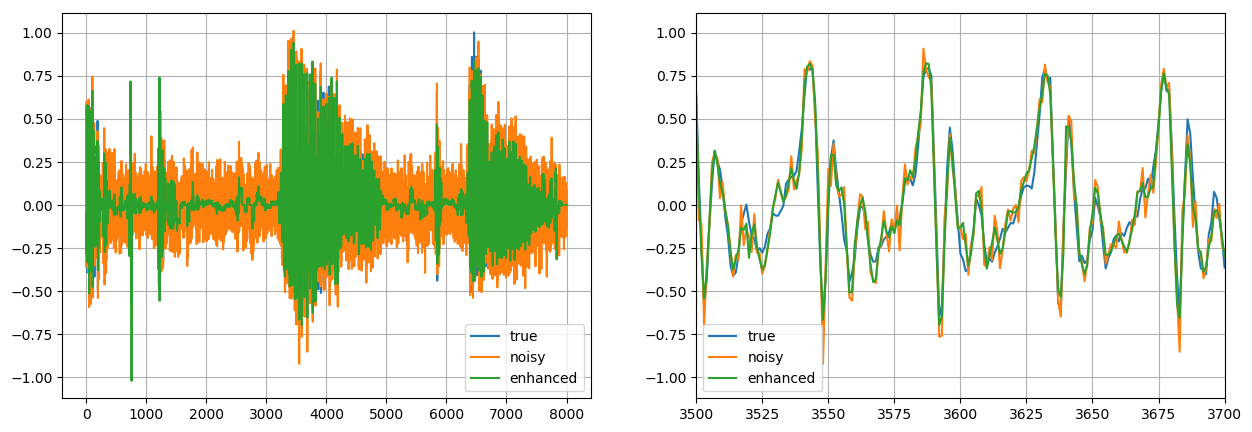

In [22]:
# plot signals
_, ax = plt.subplots(ncols=2, figsize=(15,5))
ax[1].plot(y_speech_true, label="true")
ax[1].plot(y_speech_n, label="noisy")
ax[1].plot(y_enhanced, label="enhanced")
ax[2].plot(y_speech_true, label="true")
ax[2].plot(y_speech_n, label="noisy")
ax[2].plot(y_enhanced, label="enhanced")
ax[1].grid(), ax[2].grid(), ax[2].set_xlim([3500, 3700]), ax[1].legend(), ax[2].legend()
audioplayers(y_speech_true, y_speech_n, y_enhanced, fs=fs)

In [23]:
mean(abs2.(y_speech_true - y_speech_n)), mean(abs2.(y_speech_true - y_enhanced))

(0.010030995314759898, 0.0031096812139755317)